In [ ]:
from keras.preprocessing import sequence
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

import os
import collections
import numpy as np
import matplotlib.pyplot as plt

import nltk

In [2]:
def analysis_text(text):
    num_lines = 0
    max_sentence_len = 0
    word_freqs = collections.Counter()
    
    for line in text:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        if len(words) > max_sentence_len:
            max_sentence_len = len(words)
        for word in words:
            word_freqs[word] += 1
        num_lines += 1
    return max_sentence_len, word_freqs, num_lines

In [3]:
file_path = os.path.join(os.getcwd(), "rnn-sentiment-training.txt")

with open(file_path, 'r') as train_data:
    max_len, word_freqs, num_lines = analysis_text(train_data)  

In [4]:
print('lines :', num_lines)
print('max word count in sentence:', max_len)
print('unique word count:', len(word_freqs))

('lines :', 7086)
('max word count in sentence:', 42)
('unique word count:', 2329)


In [5]:
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2

word_to_index = { x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES)) }
word_to_index["PAD"] = 0
word_to_index["UNK"] = 1

index_to_word = { v:k for k, v in word_to_index.items() }

In [6]:
X = np.empty((num_lines,), dtype=list)
y = np.zeros((num_lines))

i = 0
unknown_idx = word_to_index["UNK"]
with open(file_path, 'r') as train_data:
    for line in train_data:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        seqs = []
        for word in words:
            if word in word_to_index:
                seqs.append(word_to_index[word])
            else:
                seqs.append(unknown_idx)
        X[i] = seqs
        y[i] = int(label)
        i += 1

X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

In [7]:
sample = X[0]

from __future__ import print_function
for c in sample:
    print(index_to_word[c], end=' ')

PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD the da vinci code book is just awesome . 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5668, 40) (5668,)
(1418, 40) (1418,)


In [9]:
BATCH_SIZE = 32
NUM_HIDDEN = 64
NUM_EMBEDDING = 128
NUM_EPOCHS = 10

In [10]:
model = Sequential()
model.add(Embedding(vocab_size, NUM_EMBEDDING, input_length=MAX_SENTENCE_LENGTH))
model.add(SpatialDropout1D(Dropout(0.2)))
model.add(LSTM(NUM_HIDDEN, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           256256    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 305,729
Trainable params: 305,729
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='binary_crossentropy', 
              optimizer="adam", 
              metrics=["accuracy"])

In [12]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_test, y_test))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 8s 1ms/step - loss: 0.2342 - acc: 0.9111 - val_loss: 0.0408 - val_acc: 0.9873
Epoch 2/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0286 - acc: 0.9912 - val_loss: 0.0332 - val_acc: 0.9901
Epoch 3/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0079 - acc: 0.9982 - val_loss: 0.0300 - val_acc: 0.9908
Epoch 4/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0085 - acc: 0.9975 - val_loss: 0.0319 - val_acc: 0.9873
Epoch 5/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0327 - val_acc: 0.9922
Epoch 6/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0027 - acc: 0.9993 - val_loss: 0.0379 - val_acc: 0.9901
Epoch 7/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0373 - val_acc: 0.9908
Epoch 8/10
566

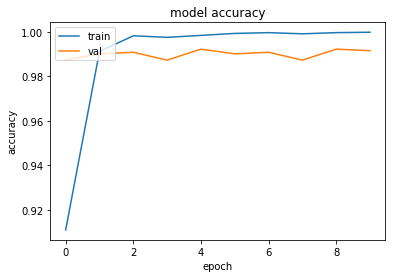

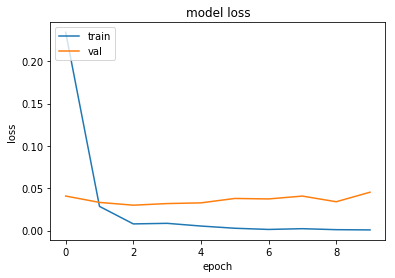

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
score, acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print("Test loss:", score)
print("Test accuracy:", acc)
print("\n")
print("[Prediction vs Truth] \t Target Sentence")

for i in range(5):
    idx = np.random.randint(len(X_test))
    x_test = X_test[idx].reshape(1,40)
    label = y_test[idx]
    pred = model.predict(x_test)[0][0]
    p = " ".join([index_to_word[x] for x in x_test[0].tolist() if x != 0])
    print("[%.03f vs %d] \t %s" % (pred, label, p))

1418/1418 [==============================] - 0s 222us/step
Test loss: 0.04528459170743743
Test accuracy: 0.9915373765867419


[Prediction vs Truth] 	 Target Sentence
[0.000 vs 0] 	 this quiz sucks and harry potter sucks ok bye..
[0.000 vs 0] 	 ok brokeback mountain is such a horrible movie .
[1.000 vs 1] 	 mission impossible 2 rocks ! ! ... .
[0.000 vs 0] 	 friday hung out with kelsie and we went and saw the da vinci code sucked ! ! ! ! !
[0.000 vs 0] 	 and that harry potter sucks because he rides on a UNK .
